# Export der Ebenen
Dieses Dokument beschreibt den Prozess der Datenaufbereitung vom Laden aus der MongoDB bis zum exportieren der Trainingsdatensätze als csv.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import copy
import plotBib
import mongodbImportBib
import dataProcessingBib
import importlib

In [222]:
dtStart = datetime(2019,12,16,11,15)
dtEnd = datetime(2019,12,16,11,45)
print("Z1-Count: "+str(mongodbImportBib.countInValues(dtStart,dtEnd,["12430012063.Z1_Axis.Actual_Position_MCS"])))
print("Reib: "+str(mongodbImportBib.countInNCProgram(dtStart,dtEnd)))
print("Values: "+str(mongodbImportBib.countInValues(dtStart,dtEnd)))

Z1-Count: 0
Reib: 0
Values: 0


In [207]:
dfTimeFrame = mongodbImportBib.loadAll_values(dtStart, dtEnd, ["12430012063.Z1_Axis.Actual_Position_MCS"])
dfReibDaten = mongodbImportBib.loadReibdaten_ncprogram(dtStart,dtEnd)

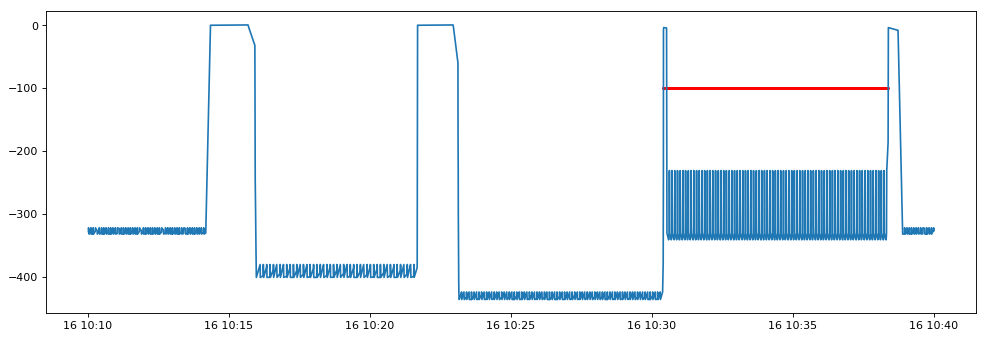

In [208]:
fig = plt.figure(figsize=(15, 5), dpi=80)
zAxisData = dfTimeFrame.loc[lambda l: l['ValueID'] == "12430012063.Z1_Axis.Actual_Position_MCS",:]
plt.plot(zAxisData.timeStamp,zAxisData.value)
plt.scatter(dfReibDaten.timeStamp,[-100]*len(dfReibDaten), s=1.0,c='r')
plt.show()

In [209]:
FOLDER = "_ebene26/"
dfTimeFrame.to_csv(FOLDER+"Z1.csv",index=False,sep=",",encoding="utf-8")
dfReibDaten.to_csv(FOLDER+"Reibdaten.csv",index=False,sep=",",encoding="utf-8")

In [211]:
dtSampleStart = datetime(2019,12,16,10,33)
dtSampleEnd = datetime(2019,12,16,10,35)

dtNewStart,dtNewEnd = dataProcessingBib.approxRangeInSteps(dfTimeFrame,dtSampleStart,dtSampleEnd)
print(str(dtNewStart))
print(str(dtNewEnd))
dfEineEbene = dfTimeFrame.loc[lambda l: ((dtNewStart <= l.timeStamp) & (l.timeStamp <= dtNewEnd)),:]

Min. sampled value: -346.23
Max. sampled value: -226.23
2019-12-16 10:30:32
2019-12-16 10:38:22


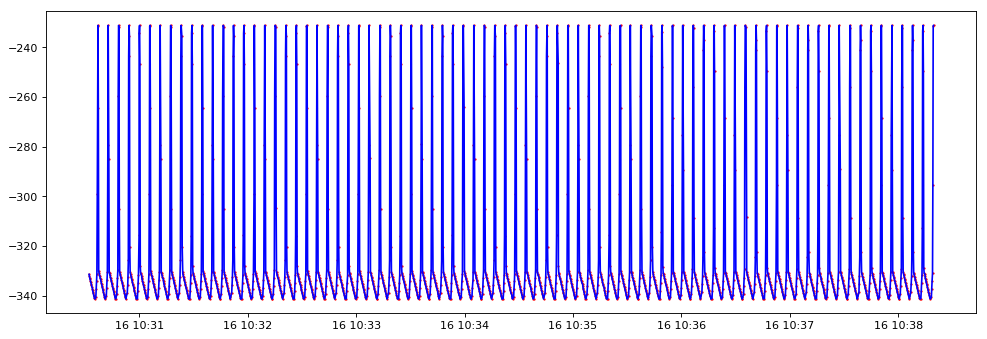

In [212]:
fig = plt.figure(figsize=(15, 5), dpi=80)
zAxisEineEbene = dfEineEbene.loc[lambda l: l.ValueID == "12430012063.Z1_Axis.Actual_Position_MCS",:]
plt.plot(zAxisEineEbene.timeStamp,zAxisEineEbene.value, c='b')
plt.scatter(zAxisEineEbene.timeStamp,zAxisEineEbene.value,c='r',s=1)
plt.show()

In [213]:
# Versuch über die Steigung: ist die Steigung links des Punktes positiv, und rechts davon negativ, so handelt es sich um eine Spitze
zAxisEineEbene = dfEineEbene.loc[lambda l: l.ValueID == "12430012063.Z1_Axis.Actual_Position_MCS",:]
dfTops = pd.DataFrame()
for i in range(1,zAxisEineEbene.shape[0]-1):
    diff1 = zAxisEineEbene.iloc[i].value - zAxisEineEbene.iloc[i-1].value # muss positiv sein
    diff2 = zAxisEineEbene.iloc[i].value - zAxisEineEbene.iloc[i+1].value # muss auch positiv sein
    if diff1 > 0 and diff2 > 0:
        dfTops = dfTops.append(zAxisEineEbene.iloc[i])
print(len(dfTops))

80


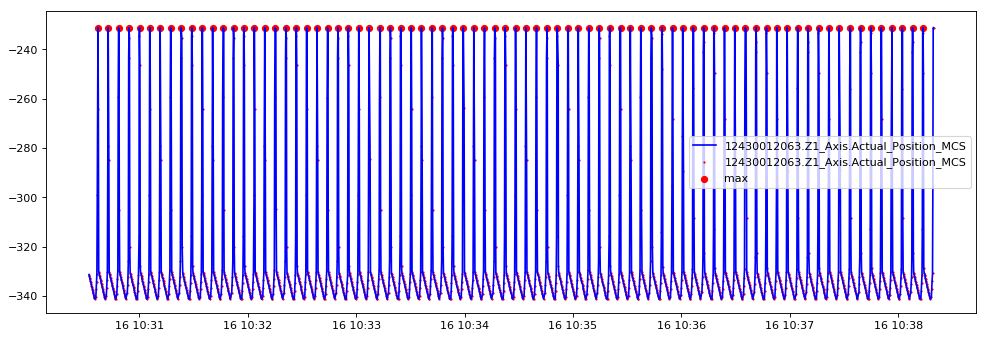

In [214]:
fig = plt.figure(figsize=(15, 5), dpi=80)
zAxisEineEbene = dfEineEbene.loc[lambda l: l.ValueID == "12430012063.Z1_Axis.Actual_Position_MCS",:]
plt.plot(zAxisEineEbene.timeStamp,zAxisEineEbene.value, c='b')
plt.scatter(zAxisEineEbene.timeStamp,zAxisEineEbene.value,c='r',s=1)
plt.scatter(dfTops.timeStamp, dfTops.value, c='r',s=30)

plt.legend(["12430012063.Z1_Axis.Actual_Position_MCS","12430012063.Z1_Axis.Actual_Position_MCS", "max"])
plt.show()

Der letzte und der erste Punkt müssen manuell hinzugefügt werden

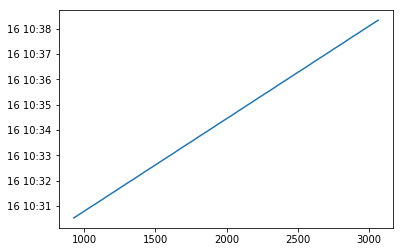

82


In [215]:
dfTops = dfTops.append(zAxisEineEbene.iloc[0])
dfTops = dfTops.append(zAxisEineEbene.iloc[-1])
dfTops = dfTops.sort_values(by="timeStamp")
plt.plot(dfTops.timeStamp)
plt.show()
print(len(dfTops))

In [216]:
#ersten und letzten timestamp zum download ALLER daten aus der value-tabelle hernehmen, dann fortfahren.
print(dfTops.iloc[0].timeStamp)
print(dfTops.iloc[-1].timeStamp)
print(mongodbImportBib.countInValues(dfTops.iloc[0].timeStamp,dfTops.iloc[-1].timeStamp))
dfTimeFrameAll = mongodbImportBib.loadAll_values(dfTops.iloc[0].timeStamp, dfTops.iloc[-1].timeStamp)
dfTimeFrameAll.head()

2019-12-16 10:30:32.157000
2019-12-16 10:38:19.537000
15981


,_id,ValueID,value,timeStamp
0,5df75d078e15b328ac24849c,12430012063.Main_Spindle.Actual_Power,0.00,2019-12-16 10:30:32.171
1,5df75d078e15b328ac24849d,12430012063.Main_Spindle.Actual_Position_MCS,269.90,2019-12-16 10:30:32.172
2,5df75d078e15b328ac24849b,12430012063.Main_Spindle.Actual_Speed_Rate,951.00,2019-12-16 10:30:32.172
3,5df75d078e15b328ac24849e,12430012063.Tool_Control_Center.Bending_Moment,3.00,2019-12-16 10:30:32.176
4,5df75d078e15b328ac24849f,12430012063.Energy_Savings.Active_Power_Spindle1,-38.35,2019-12-16 10:30:32.187


In [217]:
dfTimeFrameAll.to_csv(FOLDER+"all_values.csv",encoding="utf-8")

In [218]:
ls = []
for start,end in zip(dfTops.iloc[:-1,:].timeStamp,dfTops.iloc[1:,:].timeStamp):
    curData = dfTimeFrameAll.loc[lambda l: ((start <= l.timeStamp) & (l.timeStamp <= end)),["ValueID","value","timeStamp"]]
    curData = curData.groupby(by="ValueID", as_index=False).mean().T
    curData.columns = curData.iloc[0]
    curData.drop(curData.index[0], inplace=True)
    curData["timeStamp"] = start
    ls.append(curData)
dfData = pd.concat(ls, ignore_index=True, sort=False)
dfData.sort_values(by=["timeStamp"], inplace=True)
dfData["Label"] = "-"

In [219]:
dfData.shape

(81, 28)

In [220]:
dfData.to_csv(FOLDER+"zwischenspeicher.csv",encoding="utf-8")

# Labeln
für alle Ordner: lade den zwischenspeicher, lade die Messergebnisse aller Ebenen. Hänge die messergebnisse an den zwischenspeicher und erzeuge eine entsprechende csv. Erzeuge am ende eine CSV mit allen Daten.

In [36]:
dfAlleMessergebnisse = pd.read_csv("csv_Files/Messergebnisse_alle_ebenen.csv", sep=';', skiprows=7)
dfAlleMessergebnisse.rename(columns={"Klassifizierung nach Messchraube":"Messschraube","Klassifizierung nach Messtaster":"Messtaster","Klassifizierung nach Grenzlehrdorn":"Grenzlehrdorn"},inplace=True)

folderPrefix="_ebene"
folders = [1,15,16,22,23,24,25,6,8,9]

ls = []

for eNum in folders:
    curZwischenspeicher = pd.read_csv(folderPrefix+str(eNum)+"/zwischenspeicher.csv")
    del curZwischenspeicher['Label']
    curZwischenspeicher["Messschraube"] = "-"
    curZwischenspeicher["Messtaster"] = "-"
    curZwischenspeicher["Grenzlehrdorn"] = "-"
    curZwischenspeicher["Ebene"] = eNum
    curZwischenspeicher["Bohrung"] = 0
    for i in range(0,81):
        curZwischenspeicher.at[i,"Messschraube"] = dfAlleMessergebnisse.loc[lambda l: ((l.Ebene == eNum) & (l.Bohrung == i+1)), "Messschraube"].values[0]
        curZwischenspeicher.at[i,"Messtaster"] = dfAlleMessergebnisse.loc[lambda l: ((l.Ebene == eNum) & (l.Bohrung == i+1)), "Messtaster"].values[0]
        curZwischenspeicher.at[i,"Grenzlehrdorn"] = dfAlleMessergebnisse.loc[lambda l: ((l.Ebene == eNum) & (l.Bohrung == i+1)), "Grenzlehrdorn"].values[0]
        curZwischenspeicher.at[i,"Bohrung"] = i+1
    curZwischenspeicher.to_csv(folderPrefix+str(eNum)+"/labeledData.csv",encoding="utf-8",sep=",")
    ls.append(curZwischenspeicher)
dfData = pd.concat(ls, ignore_index=True, sort=False)
dfData.sort_values(by=["timeStamp"], inplace=True)
dfData.to_csv("allLabeled.csv", encoding="utf-8",sep=",")

# ANDERES (wurde jetzt noch nicht verwendet)

Nun muss das entsprechende Messprotokoll geladen und die eingereichtete Spalte damit befüllt werden.

Das zugehörige Messprotokoll wird mittels "importbib.importMeasurementData('csv_Files/MEAS_PROTOCOL_CSV_E1.CSV')" eingelesen und in ein Pandas-Dataframe geschrieben. Hierbei muss beachtet werden, dass das Messprotokoll zur richtigen Ebene geladen wird, da die Timestamps nicht übereinstimmen, weil die Messung zeitlich versetzt stattfindet.

In [14]:
# Einlesen der Daten des Messprotokolls
dfMeas = importbib.importMeasurementData('csv_Files/MEAS_PROTOCOL_CSV_E1.CSV')
dfMeas.head(-1)

,Date,Time,Program,Workpiece no.,Testpoint,Plane,Probe no.,Cycle,S_MVAR,Measuring variant,Results,Setpoint,Measured,Difference,Unit
0,2019-11-20,12:14:13,REIBEN.MPF,,1,G17,1,977,1,1 Hole,X,"15,000","14,976","-0,024",mm
1,2019-11-20,12:14:13,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Y,"15,000","15,016","0,016",mm
2,2019-11-20,12:14:13,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Diameter,"12,009","12,019","0,010",mm
3,2019-11-20,12:14:18,REIBEN.MPF,,1,G17,1,977,1,1 Hole,X,"30,000","29,994","-0,006",mm
4,2019-11-20,12:14:18,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Y,"15,000","14,986","-0,014",mm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2019-11-20,12:21:06,REIBEN.MPF,,1,G17,1,977,1,1 Hole,X,"120,000","120,005","0,005",mm
238,2019-11-20,12:21:06,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Y,"135,000","135,001","0,000",mm
239,2019-11-20,12:21:06,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Diameter,"12,009","12,018","0,009",mm
240,2019-11-20,12:21:10,REIBEN.MPF,,1,G17,1,977,1,1 Hole,X,"135,000","134,987","-0,013",mm


In der Spalte "Difference" ist das Messergebnis des Lochs. Die dazugehörigen Daten liegen in sehr ungeordneter Weise vor. Wir haben Spalten, die mehrere Leerzeichen und ungünstig formatierte Strings beinhalten. Diese Spalten müssen wir für die Auswertung erst aufbereiten. 

**Achtung**: Die nachfolgenden Zellen immer nur einmal ausführen. Sonst stimmt das Ausgangs-DataFrame nicht mehr. Bei mehrmaliger Ausführung neues Dataframe laden.

In [15]:
# Transformation des Pandas-Dataframe zur List und Umwandlung der Strings in Floats
dfMeas = importbib.transformStringListToFloatList(dfMeas, 'Setpoint')
dfMeas = importbib.transformStringListToFloatList(dfMeas, 'Measured')
dfMeas = importbib.transformStringListToFloatList(dfMeas, 'Difference')

In [17]:
# Serialisierung der Daten in eine CSV-Datei
dfMeas.to_csv("csv_Files/MEAS_PROTOCOL_CSV_E1_TRAININGDATA.csv",index=False,encoding="utf-8")

In [11]:
listMeas_setPoint = dfMeas['Setpoint']

# Separierung der Setpoint-Werte
listMeas_setPointX = listMeas_setPoint[0::3]
listMeas_setPointY = listMeas_setPoint[1::3]
listMeas_setPointDia = listMeas_setPoint[2::3]

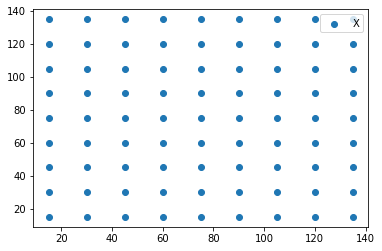

In [12]:
# Plotten der Messpunkte
plt.scatter(listMeas_setPointX, listMeas_setPointY)

plt.legend(["X","Y"])
plt.show()

Wie gut zu sehen ist, entsteht ein klares Raster der Messpunkte. Mit den Maschinendaten zusammen bildet sich ein umfassendes Gesamtbild der gewonnenen Daten.

Im letzten Schritt werden noch die Achsleistungdaten aufbereitet und versucht in Verbindung mit dem restlichen Daten zu bringen.

In [18]:
# Einlesen der Daten der Achsleistung
dfAchs = importbib.importAchsleistungsData('csv_Files/Achsleistung-2019-11-20T10-27-03_E1.csv')
dfAchs.head(10)

,Timestamp,X1,Y1,Z1,C1,A1,SPI1,WZM,X1 (mech),Y1 (mech),Z1 (mech),C1 (mech),A1 (mech),SPI1 (mech),WZM (mech)
0,"2019-11-20T10:27:03,117",232.660,211.220,3145.891,313.976,1496.938,1761.312,0.0,0.0,0.0,3993.138,0.0,0.0,460.194,0.0
1,"2019-11-20T10:27:03,127",232.660,215.914,3148.384,317.148,1493.766,1193.998,0.0,0.0,0.0,3993.138,0.0,0.0,460.194,0.0
2,"2019-11-20T10:27:03,129",232.660,215.914,3148.384,317.148,1493.766,1193.998,0.0,0.0,0.0,0.000,0.0,0.0,479.369,0.0
3,"2019-11-20T10:27:03,139",230.884,220.608,3148.384,307.633,1493.766,705.844,0.0,0.0,0.0,0.000,0.0,0.0,479.369,0.0
4,"2019-11-20T10:27:03,141",230.884,220.608,3148.384,307.633,1493.766,705.844,0.0,0.0,0.0,0.000,0.0,0.0,383.495,0.0
5,"2019-11-20T10:27:03,320",234.436,215.914,3148.384,294.947,1490.595,1398.495,0.0,0.0,0.0,0.000,0.0,0.0,383.495,0.0
6,"2019-11-20T10:27:03,321",234.436,215.914,3148.384,294.947,1490.595,1398.495,0.0,0.0,0.0,0.000,0.0,0.0,766.990,0.0
7,"2019-11-20T10:27:03,517",232.660,218.261,3160.847,275.919,1493.766,1517.235,0.0,0.0,0.0,0.000,0.0,0.0,766.990,0.0
8,"2019-11-20T10:27:03,519",232.660,218.261,3160.847,275.919,1493.766,1517.235,0.0,0.0,0.0,0.000,0.0,0.0,843.689,0.0
9,"2019-11-20T10:27:03,717",232.660,211.220,3155.862,266.404,1487.423,2025.179,0.0,0.0,0.0,0.000,0.0,0.0,843.689,0.0


In [ ]:
dfData.to_csv("csv_Files/data_2019-26-11_TRAININGDATA.csv",index=False,encoding="utf-8")